In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/__AvengersAssemble__

/content/drive/MyDrive/__AvengersAssemble__


In [3]:
ls

Avengers/                             avengers_triplet_model_full.pth
AvengersAssemble.ipynb                best_avengers_model.pt
avengers_face_recog_triplet_full.pth  best_avengers_tf_resnet50.h5
avengers_face_recog_triplet.pth       best_triplet_model.pth
avengers_pytorch_resnet18.pth         draft.ipynb
avengers_tf_resnet50_final.h5         known_embeddings.pkl


In [4]:
# ---- 1) 📚 Import Libraries ----
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

In [5]:
# ---- 2) Data ----
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder('Avengers/train', transform=transform)
val_dataset   = datasets.ImageFolder('Avengers/val', transform=transform)
test_dataset  = datasets.ImageFolder('Avengers/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("Classes:", train_dataset.classes)

Classes: ['chris_evans', 'chris_hemsworth', 'mark_ruffalo', 'robert_downey_jr', 'scarlett_johansson']


In [6]:
# ---- 3) Model ----
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_classes = len(train_dataset.classes)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 188MB/s]


In [7]:
# ---- 4) EarlyStopping & Tracking ----
num_epochs = 15
patience = 3
best_val_loss = float('inf')
trigger_times = 0

train_losses = []
train_accs = []
val_losses = []
val_accs = []

In [8]:
# ---- 5) Training Loop ----
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0  # ✅ For training accuracy

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # ✅ Count correct predictions for training
        _, preds = torch.max(outputs, 1)
        correct_train += torch.sum(preds == labels).item()
        total_train += labels.size(0)

    # ✅ Compute train loss & train acc
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct_train / total_train

    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # ---- Validation ----
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

    val_loss /= len(val_loader.dataset)
    val_acc = correct / total

    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {epoch_loss:.4f} | Train Accuracy: {epoch_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Accuracy: {val_acc:.4f}")

    scheduler.step()

    # ---- EarlyStopping ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_avengers_model.pt')
        print("✅ Validation loss improved — model saved.")
        trigger_times = 0
    else:
        trigger_times += 1
        print(f"⚠️ No improvement. EarlyStopping counter: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("⏹️ Early stopping triggered!")
            break

    print("."*100)

Epoch 1/15:
Train Loss: 1.6283 | Train Accuracy: 0.2701
Val   Loss: 1.3725 | Val   Accuracy: 0.4500
✅ Validation loss improved — model saved.
....................................................................................................
Epoch 2/15:
Train Loss: 1.3238 | Train Accuracy: 0.4854
Val   Loss: 1.0766 | Val   Accuracy: 0.6500
✅ Validation loss improved — model saved.
....................................................................................................
Epoch 3/15:
Train Loss: 1.0843 | Train Accuracy: 0.6606
Val   Loss: 0.8775 | Val   Accuracy: 0.8333
✅ Validation loss improved — model saved.
....................................................................................................
Epoch 4/15:
Train Loss: 0.9894 | Train Accuracy: 0.6861
Val   Loss: 0.7119 | Val   Accuracy: 0.8833
✅ Validation loss improved — model saved.
....................................................................................................
Epoch 5/15:
Train Loss: 0.87

In [9]:
# ---- 6) Load Best ----
model.load_state_dict(torch.load('best_avengers_model.pt'))
print("Best model loaded.")

Best model loaded.


In [10]:
# ---- 7) Final Test Accuracy ----
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)

test_acc = correct / total
print(f"Final Test Accuracy: {test_acc:.4f}")

Final Test Accuracy: 0.9000


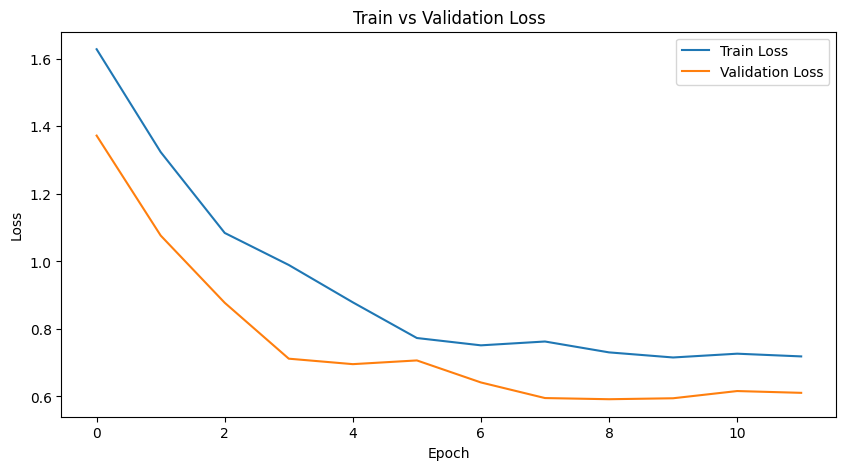

In [11]:
# ---- 8) 📊 Plot Training & Validation Loss ----
# Visualize loss curves to check for underfitting or overfitting.
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

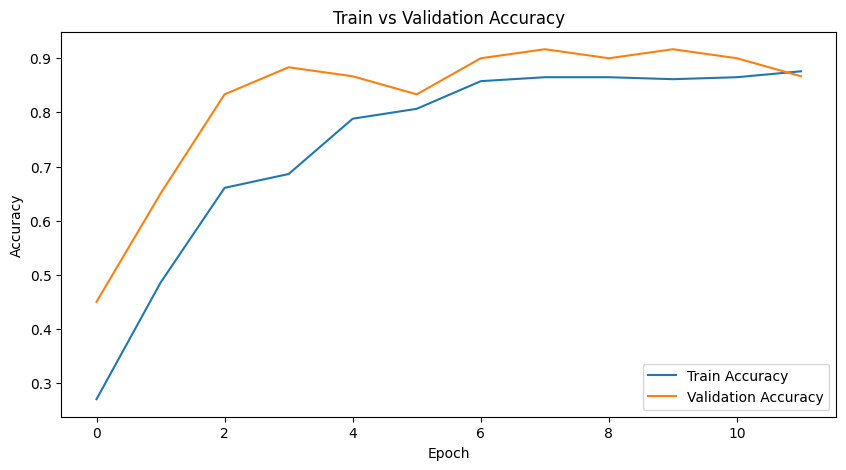

In [12]:
# ---- 9) 📈 Plot Train vs Validation Accuracy ----
# Visualize how training and validation accuracy changed during training.
plt.figure(figsize=(10,5))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

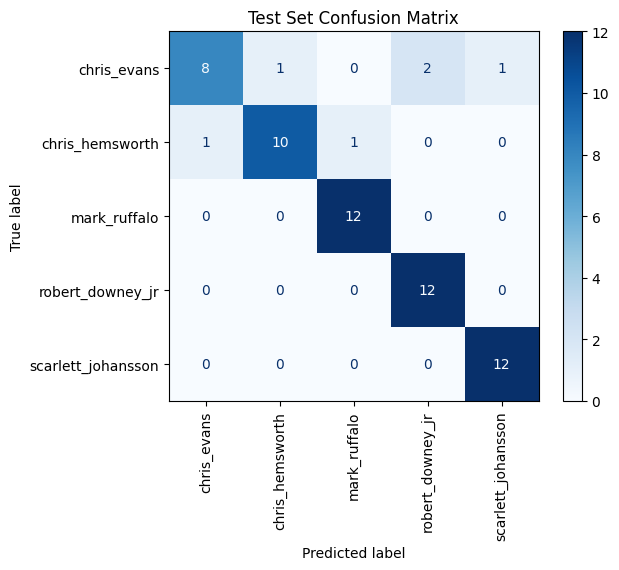

In [13]:
# ---- 10) 📊 Confusion Matrix ----
# Display confusion matrix to analyze per-class performance.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap='Blues')
plt.title('Test Set Confusion Matrix')
plt.xticks(rotation=90)
plt.show()

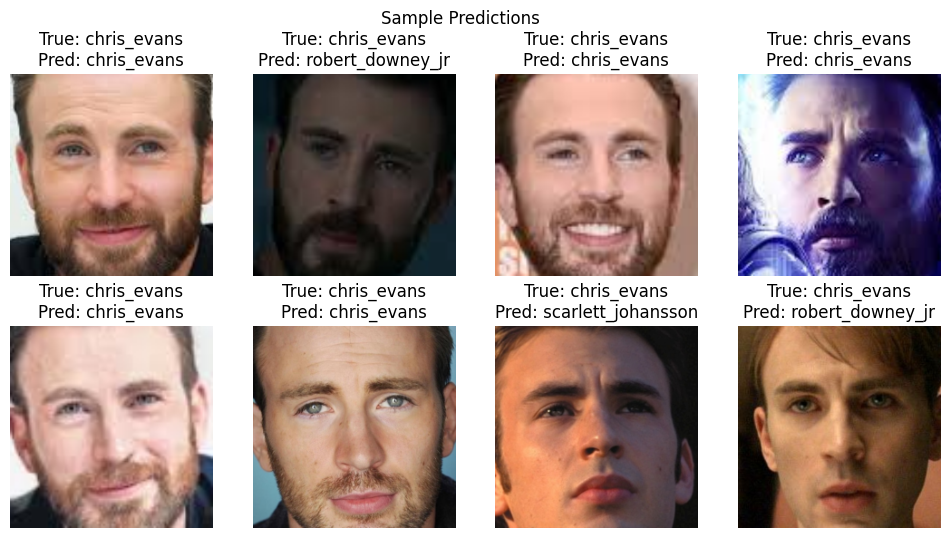

In [14]:
# ---- 11) 🖼️ Show Sample Predictions ----
# Display some test images with true vs. predicted labels.
inputs, labels = next(iter(test_loader))
inputs, labels = inputs.to(device), labels.to(device)
outputs = model(inputs)
_, preds = torch.max(outputs, 1)

fig = plt.figure(figsize=(12, 6))
for idx in range(8):
    ax = fig.add_subplot(2, 4, idx+1)
    img = inputs[idx].cpu().permute(1, 2, 0)
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img = img.numpy().clip(0, 1)

    ax.imshow(img)
    ax.set_title(f"True: {train_dataset.classes[labels[idx]]}\nPred: {train_dataset.classes[preds[idx]]}")
    ax.axis('off')

plt.suptitle('Sample Predictions')
plt.show()

In [15]:
# ---- 12) 💾 Save Final Model ----
# Save your final trained model for deployment or reuse
torch.save(model.state_dict(), 'avengers_pytorch_resnet18.pth')
print("Model saved!")

Model saved!


In [16]:
# ---- 1) 📚 Import Libraries ----
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [17]:
# ---- 2) 📁 Load Data ----
img_size = (224, 224)
batch_size = 16

from tensorflow.keras.applications.resnet50 import preprocess_input

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    'Avengers/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    'Avengers/val',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    'Avengers/test',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # For confusion matrix!
)

print("✅ Classes:", train_gen.class_indices)

Found 274 images belonging to 5 classes.
Found 60 images belonging to 5 classes.
Found 60 images belonging to 5 classes.
✅ Classes: {'chris_evans': 0, 'chris_hemsworth': 1, 'mark_ruffalo': 2, 'robert_downey_jr': 3, 'scarlett_johansson': 4}


In [18]:
# ---- 3) 🧠 Build Model ----
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base layers

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(len(train_gen.class_indices), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │        10,245 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,597,957 (90.02 MB)

 Trainable params: 10,245 (40.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [19]:
# ---- 4) 🛑 Add EarlyStopping ----
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Optional: ModelCheckpoint
checkpoint = callbacks.ModelCheckpoint(
    'best_avengers_tf_resnet50.h5',
    monitor='val_loss',
    save_best_only=True
)

In [20]:
# ---- 5) 🚂 Train ----
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[early_stop, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.2803 - loss: 1.7075

18/18 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.2847 - loss: 1.6984 - val_accuracy: 0.6167 - val_loss: 1.0338
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.5959 - loss: 1.0582

18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 230ms/step - accuracy: 0.5987 - loss: 1.0524 - val_accuracy: 0.7000 - val_loss: 0.7535
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7847 - loss: 0.7400

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - accuracy: 0.7851 - loss: 0.7382 - val_accuracy: 0.8333 - val_loss: 0.5151
Epoch 4/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8653 - loss: 0.5527

18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - accuracy: 0.8667 - loss: 0.5511 - val_accuracy: 0.9000 - val_loss: 0.4020
Epoch 5/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9355 - loss: 0.4305

18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step - accuracy: 0.9347 - loss: 0.4312 - val_accuracy: 0.9833 - val_loss: 0.3134
Epoch 6/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9067 - loss: 0.4351

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - accuracy: 0.9080 - loss: 0.4320 - val_accuracy: 0.9833 - val_loss: 0.2549
Epoch 7/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9652 - loss: 0.3294

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step - accuracy: 0.9653 - loss: 0.3281 - val_accuracy: 0.9667 - val_loss: 0.2125
Epoch 8/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9526 - loss: 0.2785

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 0.9528 - loss: 0.2779 - val_accuracy: 1.0000 - val_loss: 0.2029
Epoch 9/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9717 - loss: 0.2390

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.9718 - loss: 0.2387 - val_accuracy: 0.9833 - val_loss: 0.1680
Epoch 10/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9834 - loss: 0.2047

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step - accuracy: 0.9837 - loss: 0.2052 - val_accuracy: 1.0000 - val_loss: 0.1421
Epoch 11/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - accuracy: 0.9814 - loss: 0.2059 - val_accuracy: 1.0000 - val_loss: 0.1513
Epoch 12/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9994 - loss: 0.1727

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 242ms/step - accuracy: 0.9992 - loss: 0.1727 - val_accuracy: 1.0000 - val_loss: 0.1119
Epoch 13/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 0.1421

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step - accuracy: 1.0000 - loss: 0.1422 - val_accuracy: 1.0000 - val_loss: 0.1027
Epoch 14/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9981 - loss: 0.1322 - val_accuracy: 1.0000 - val_loss: 0.1086
Epoch 15/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 0.1146

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - accuracy: 1.0000 - loss: 0.1149 - val_accuracy: 1.0000 - val_loss: 0.0923


In [21]:
# ---- 6) ✅ Load Best Model ----
# Note: If EarlyStopping restored best weights, you’re good.
# Else, reload best saved weights:
model = tf.keras.models.load_model('best_avengers_tf_resnet50.h5')
print("✅ Best model loaded.")

✅ Best model loaded.


In [22]:
# ---- 7) 📊 Final Test Accuracy ----
loss, acc = model.evaluate(test_gen)
print(f"✅ Final Test Accuracy: {acc:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 807ms/step - accuracy: 1.0000 - loss: 0.1185
✅ Final Test Accuracy: 1.0000


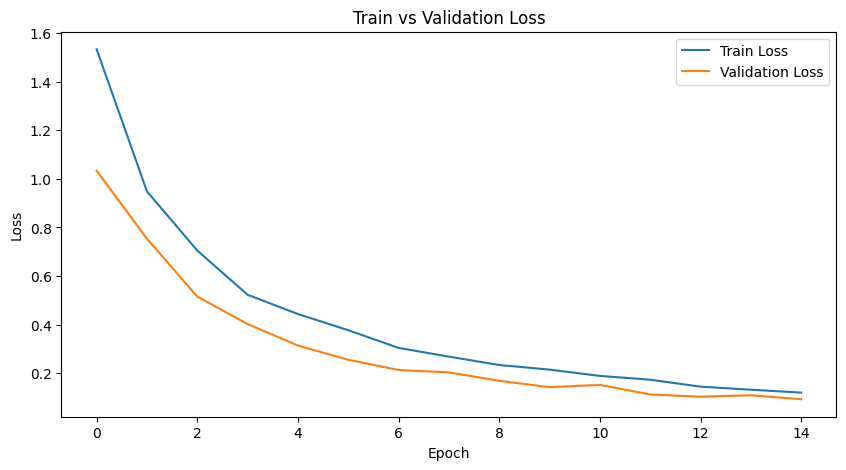

In [23]:
# ---- 8) 📈 Plot Training & Validation Loss ----
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

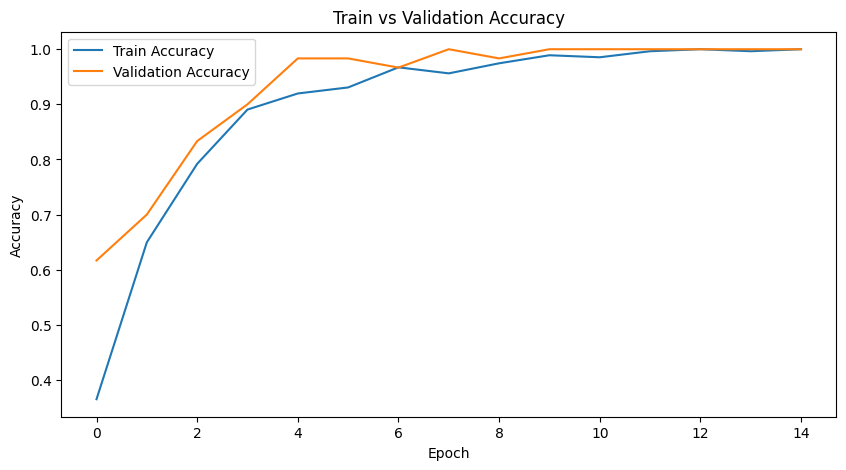

In [24]:
# ---- 9) 📈 Plot Train vs Validation Accuracy ----
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


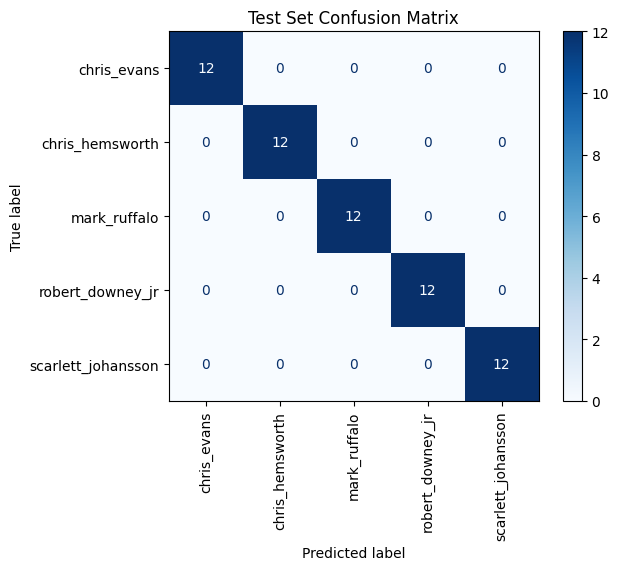

In [25]:
# ---- 10) 📊 Confusion Matrix ----
# Get predictions & true labels
Y_pred = model.predict(test_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_gen.classes

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(train_gen.class_indices.keys()))
disp.plot(cmap='Blues')
plt.title('Test Set Confusion Matrix')
plt.xticks(rotation=90)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


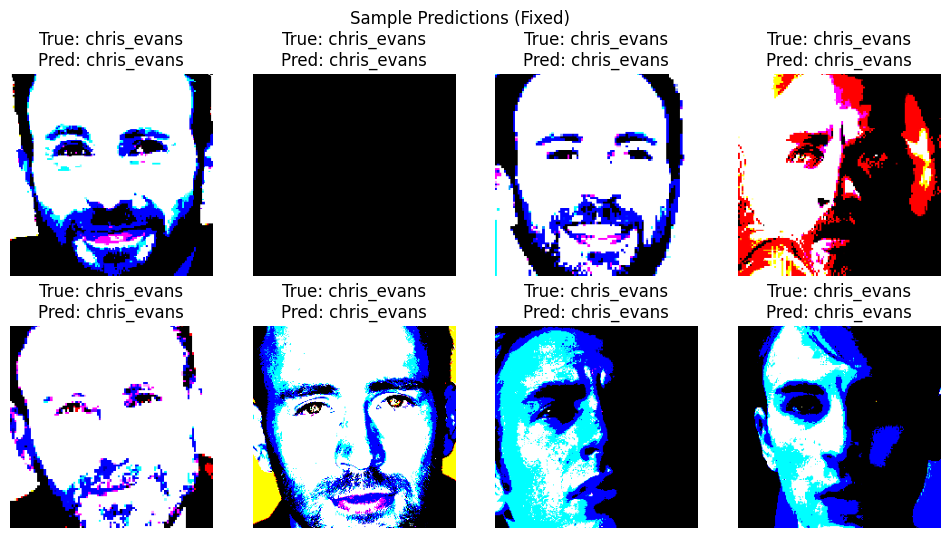

In [26]:
# ---- 11) 🖼️ Show Sample Predictions ----
# Grab some test images & predictions
sample_batch = next(iter(test_gen))
images, labels = sample_batch

# Undo preprocess_input for ResNet50: [-1, 1] → [0, 1]
images_display = (images + 1) / 2.0

preds = model.predict(images)
pred_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(labels, axis=1)

fig = plt.figure(figsize=(12, 6))
for idx in range(8):
    ax = fig.add_subplot(2, 4, idx+1)
    ax.imshow(np.clip(images_display[idx], 0, 1))  # 👈 Safe clipping
    true_label = list(train_gen.class_indices.keys())[true_classes[idx]]
    pred_label = list(train_gen.class_indices.keys())[pred_classes[idx]]
    ax.set_title(f"True: {true_label}\nPred: {pred_label}")
    ax.axis('off')

plt.suptitle('Sample Predictions (Fixed)')
plt.show()

In [27]:
# ---- 12) 💾 Save Final Model ----
# Save your final trained model for deployment or reuse
model.save('avengers_tf_resnet50_final.h5')
print("✅ Final model saved as 'avengers_tf_resnet50.h5'")

✅ Final model saved as 'avengers_tf_resnet50.h5'


In [39]:
# 📸 STEP 1: Take a photo
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const video = document.createElement('video');
      const canvas = document.createElement('canvas');
      const button = document.createElement('button');

      button.textContent = 'Take Photo';
      div.appendChild(video);
      div.appendChild(button);
      document.body.appendChild(div);

      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      video.srcObject = stream;
      await video.play();

      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;

      await new Promise((resolve) => button.onclick = resolve);

      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getTracks().forEach(track => track.stop());
      div.remove();

      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js(f'takePhoto({quality})')
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

photo_path = take_photo()
print(f"✅ Photo saved to: {photo_path}")

<IPython.core.display.Javascript object>

✅ Photo saved to: photo.jpg


In [42]:
# ------------------------------
# ✅ PyTorch pipeline
# ------------------------------

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms

# 🖼️ Preprocess
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

img_pil = Image.open(photo_path).convert('RGB')
img_tensor = preprocess(img_pil).unsqueeze(0)

print("✅ PyTorch tensor shape:", img_tensor.shape)

# ⏬ Load your model
model_pt = models.resnet18(pretrained=False)
num_ftrs = model_pt.fc.in_features
model_pt.fc = nn.Linear(num_ftrs, len(train_dataset.classes))  # Same as training

model_pt.load_state_dict(torch.load('avengers_pytorch_resnet18.pth', map_location='cpu'))
model_pt.eval()
print("✅ PyTorch model loaded.")

# 🔮 Predict
with torch.no_grad():
    outputs = model_pt(img_tensor)
    probs = F.softmax(outputs, dim=1)
    conf, pred_idx = torch.max(probs, 1)

conf = conf.item()
pred_idx = pred_idx.item()

class_labels = train_dataset.classes  # or your saved list
pred_label = class_labels[pred_idx]

threshold = 0.4

if conf >= threshold:
    print(f"🦸 You are: {pred_label} (Confidence: {conf:.2f})")
else:
    print(f"❌ Sorry, you are NOT an Avenger! (Max confidence: {conf:.2f})")

✅ PyTorch tensor shape: torch.Size([1, 3, 224, 224])
✅ PyTorch model loaded.
🦸 You are: robert_downey_jr (Confidence: 0.43)


In [41]:
# ------------------------------
# ✅ TensorFlow pipeline
# ------------------------------

# 📦 Imports
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input

# 🖼️ Preprocess
img = Image.open(photo_path).convert('RGB')
img = img.resize((224, 224))
img_array = np.expand_dims(np.array(img), axis=0)
img_array = preprocess_input(img_array)

print("✅ Preprocessed image shape:", img_array.shape)

# ⏬ Load your saved model
model_tf = tf.keras.models.load_model('avengers_tf_resnet50_final.h5')
print("✅ TensorFlow model loaded.")

# 🔮 Predict
preds = model_tf.predict(img_array)
confidences = preds[0]

# Get top prediction
max_conf = np.max(confidences)
pred_idx = np.argmax(confidences)

# Your labels
class_labels = list(train_gen.class_indices.keys())  # If you have train_gen available
# OR manually: class_labels = ['IronMan', 'Hulk', 'Thor', ...]

pred_label = class_labels[pred_idx]

# ✅ Apply threshold
threshold = 0.4

if max_conf >= threshold:
    print(f"🦸 You are: {pred_label} (Confidence: {max_conf:.2f})")
else:
    print(f"❌ Sorry, you are NOT an Avenger! (Max confidence: {max_conf:.2f})")

✅ Preprocessed image shape: (1, 224, 224, 3)


✅ TensorFlow model loaded.
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
🦸 You are: mark_ruffalo (Confidence: 0.65)
